# EDA on Dataset

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data
malware_file = '/content/drive/MyDrive/Tasks (Ruman Malik)/Task 6 (DGA Detection)/Data/DGA.txt'
benign_file = '/content/drive/MyDrive/Tasks (Ruman Malik)/Task 6 (DGA Detection)/Data/top-100000-domains.txt'

# Load domain names into lists
with open(malware_file, 'r') as f:
    dga_domains = f.read().splitlines()

with open(benign_file, 'r') as f:
    benign_domains = f.read().splitlines()


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Basic statistics
print(f'Total DGA domains: {len(dga_domains)}')
print(f'Total benign domains: {len(benign_domains)}')
print(f'Unique DGA domains: {len(set(dga_domains))}')
print(f'Unique benign domains: {len(set(benign_domains))}')


Total DGA domains: 100000
Total benign domains: 100000
Unique DGA domains: 89286
Unique benign domains: 100000


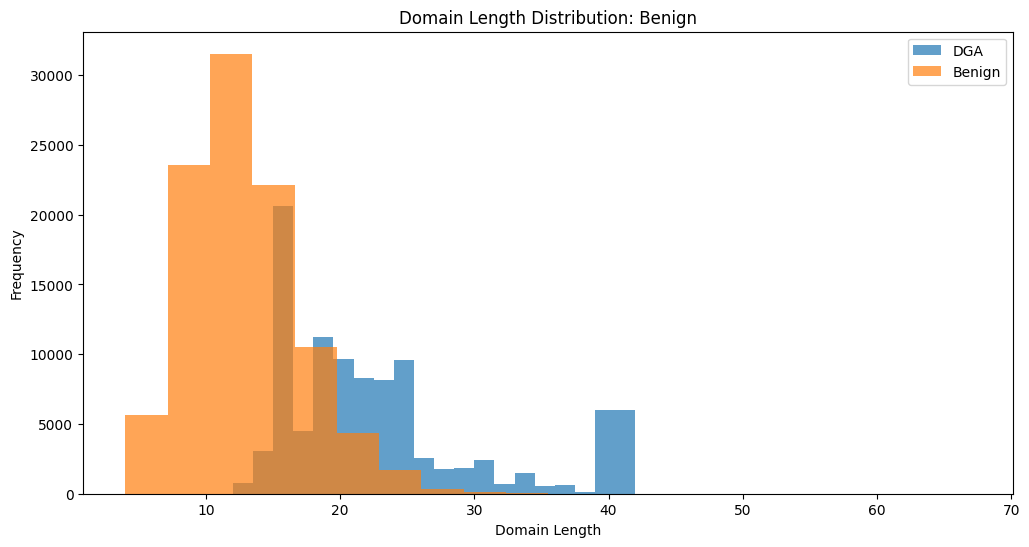

In [4]:
# Domain Length Distribution
def domain_length_distribution(domains, label):
    domain_lengths = [len(domain) for domain in domains]
    plt.hist(domain_lengths, bins=20, alpha=0.7, label=label)
    plt.xlabel('Domain Length')
    plt.ylabel('Frequency')
    plt.title(f'Domain Length Distribution: {label}')
    plt.legend()

plt.figure(figsize=(12, 6))
domain_length_distribution(dga_domains, 'DGA')
domain_length_distribution(benign_domains, 'Benign')
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


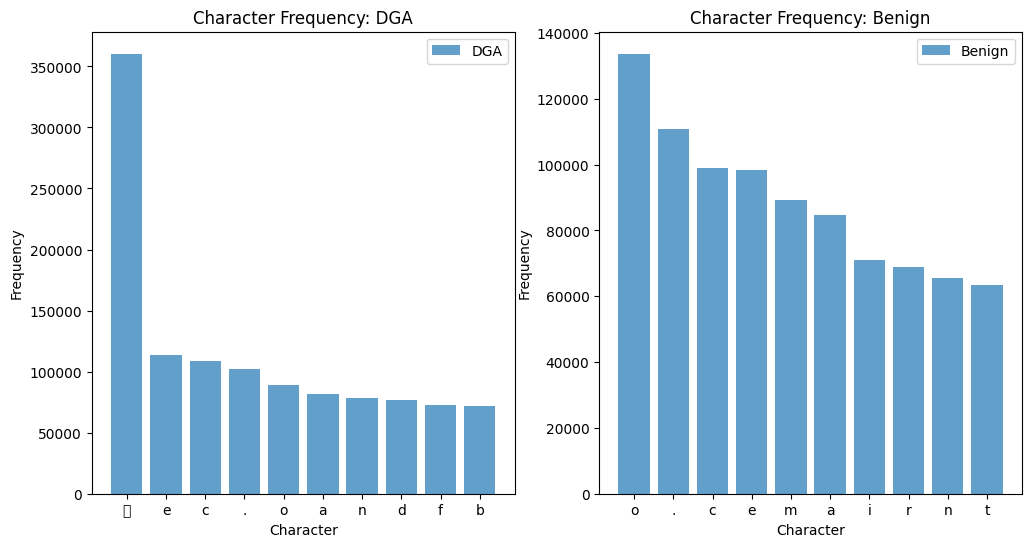

In [5]:
# Character Composition Analysis
from collections import Counter

def character_composition(domains, label):
    all_chars = ''.join(domains)
    char_freq = Counter(all_chars)
    common_chars = char_freq.most_common(10)
    chars, freqs = zip(*common_chars)
    plt.bar(chars, freqs, alpha=0.7, label=label)
    plt.xlabel('Character')
    plt.ylabel('Frequency')
    plt.title(f'Character Frequency: {label}')
    plt.legend()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
character_composition(dga_domains, 'DGA')
plt.subplot(1, 2, 2)
character_composition(benign_domains, 'Benign')
plt.show()

<ipython-input-6-44610cf15787>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dga_entropy, label='DGA', shade=True)
<ipython-input-6-44610cf15787>:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(benign_entropy, label='Benign', shade=True)


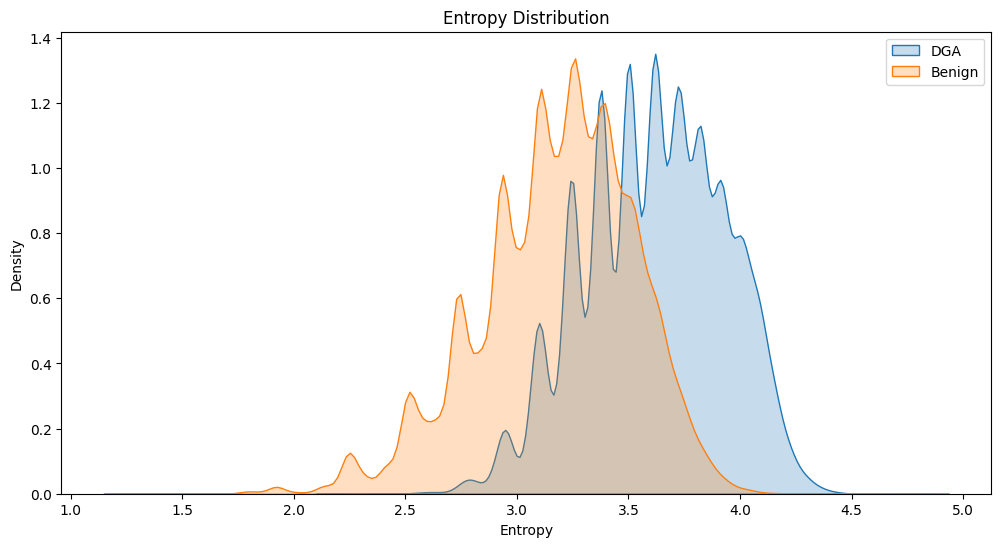

In [6]:
# Entropy Calculation
def entropy(domain):
    probs = [domain.count(c) / len(domain) for c in set(domain)]
    return -sum([p * np.log2(p) for p in probs])

dga_entropy = [entropy(domain) for domain in dga_domains]
benign_entropy = [entropy(domain) for domain in benign_domains]

plt.figure(figsize=(12, 6))
sns.kdeplot(dga_entropy, label='DGA', shade=True)
sns.kdeplot(benign_entropy, label='Benign', shade=True)
plt.title('Entropy Distribution')
plt.xlabel('Entropy')
plt.legend()
plt.show()

# DeepD2V

## 1. Introduction and Imports

In [7]:
import numpy as np
import gensim
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import re
import nltk
from collections import defaultdict
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK data if not already present
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## 2. Data Loading and Preprocessing

In [8]:
# Load dictionary and frequency data
def load_dictionary(file_path):
    dictionary = {}
    with open(file_path, 'r') as file:
        for line in file:
            word, freq = line.strip().split()
            dictionary[word] = int(freq)
    return dictionary

# Load domain data
def load_domains(file_path):
    with open(file_path, 'r') as file:
        return [line.strip() for line in file]

# Calculate word probabilities using Zipf's law
def calculate_word_probabilities(dictionary):
    sorted_words = sorted(dictionary.items(), key=lambda x: x[1], reverse=True)
    total_words = len(sorted_words)
    word_probabilities = {}
    for rank, (word, freq) in enumerate(sorted_words, start=1):
        probability = 1 / (rank * math.log(total_words))
        word_probabilities[word] = probability
    return word_probabilities

# Split domain names into words or tokens using probabilistic approach
def dom2words(domain, word_probabilities):
    tokens = re.findall(r'[a-zA-Z0-9]+', domain)  # Extract tokens of letters and numbers
    result = []

    for token in tokens:
        n = len(token)
        dp = [-float('inf')] * (n + 1)  # DP array to keep track of segmentation probabilities
        split = [None] * (n + 1)  # To store the split positions

        dp[0] = 0  # Start with zero probability

        for i in range(1, n + 1):
            for j in range(i):
                word = token[j:i]
                if word in word_probabilities:
                    prob = dp[j] + math.log(word_probabilities[word])
                    if prob > dp[i]:
                        dp[i] = prob
                        split[i] = j

        # Reconstruct the words from the split
        words = []
        idx = n
        while idx > 0:
            prev_idx = split[idx]
            if prev_idx is None:
                break
            words.append(token[prev_idx:idx])
            idx = prev_idx

        result.extend(reversed(words))

    return result


## 3. Domain Splitting

In [9]:
# Train Word2Vec model
def train_word2vec(sentences):
    model = Word2Vec(sentences, vector_size=100, window=5, sg=1, min_count=1)
    return model

# Define the function to generate embeddings
def get_embeddings(sentences, model):
    tfidf_vectorizer = TfidfVectorizer(vocabulary=model.wv.key_to_index)
    tfidf_matrix = tfidf_vectorizer.fit_transform([' '.join(sentence) for sentence in sentences])

    tfidf_weights = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_matrix.mean(axis=0).A1))

    embeddings = []
    for sentence in sentences:
        vectors = [model.wv[word] for word in sentence if word in model.wv]
        if vectors:
            vectors_array = np.array(vectors)

            # Aggregation methods
            min_vec = np.min(vectors_array, axis=0)
            mean_vec = np.mean(vectors_array, axis=0)
            max_vec = np.max(vectors_array, axis=0)
            sum_vec = np.sum(vectors_array, axis=0)

            # TF-IDF weighting
            tfidf_vec = np.zeros(vectors_array.shape[1])
            for word in sentence:
                if word in tfidf_weights:
                    tfidf_vec += model.wv[word] * tfidf_weights[word]

            # Combine all aggregations
            embeddings.append(np.concatenate([min_vec, mean_vec, max_vec, sum_vec, tfidf_vec]))
        else:
            embeddings.append(np.zeros(500))

    return np.array(embeddings)


## 4. Training Word2Vec Model and Generating Embeddings

In [10]:
# Create DeepD2V model
def create_deepd2v_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.5))

    model.add(Conv1D(128, 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.5))

    model.add(Conv1D(256, 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.5))

    model.add(Conv1D(128, 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.5))

    model.add(Conv1D(64, 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


## 5. Main Function

In [11]:
# File paths
malware_file = '/content/drive/MyDrive/Tasks (Ruman Malik)/Task 6 (DGA Detection)/Data/DGA.txt'
benign_file = '/content/drive/MyDrive/Tasks (Ruman Malik)/Task 6 (DGA Detection)/Data/top-100000-domains.txt'
dictionary_file = '/content/drive/MyDrive/Tasks (Ruman Malik)/Task 6 (DGA Detection)/Data/count_1w.txt'

# Load data
malware_domains = load_domains(malware_file)
benign_domains = load_domains(benign_file)
dictionary = load_dictionary(dictionary_file)

In [12]:
# Calculate word probabilities
word_probabilities = calculate_word_probabilities(dictionary)

In [13]:
# Preprocess domains
all_domains = malware_domains + benign_domains
sentences = [dom2words(domain, word_probabilities) for domain in all_domains]

# Print example of domain splitting
for domain, sentence in zip(all_domains, sentences):
  print(f"Domain: {domain}")
  print(f"Split into words: {sentence}")

Streaming output truncated to the last 5000 lines.
Domain: 9ye.com
Split into words: ['com']
Domain: genome.jp
Split into words: ['genome', 'jp']
Domain: traaflaab.ru
Split into words: ['tra', 'afl', 'aab', 'ru']
Domain: dermobakim.com
Split into words: ['dermo', 'b', 'akim', 'com']
Domain: hcsbk.kz
Split into words: ['hcsb', 'k', 'kz']
Domain: baibuwang.com
Split into words: ['bai', 'bu', 'wang', 'com']
Domain: wolverdon-filmes.com
Split into words: ['wol', 'verdon', 'filmes', 'com']
Domain: mirthandmotivation.com
Split into words: ['mirth', 'and', 'motivation', 'com']
Domain: lojavirtual.com.br
Split into words: ['loja', 'virtual', 'com', 'br']
Domain: portal-vt.ru
Split into words: ['portal', 'vt', 'ru']
Domain: youvisit.com
Split into words: ['you', 'visit', 'com']
Domain: hankyu-hotel.com
Split into words: ['hankyu', 'hotel', 'com']
Domain: dailyentertainmentnews.com
Split into words: ['daily', 'entertainment', 'news', 'com']
Domain: urduweb.org
Split into words: ['urdu', 'web', '

In [14]:
# Train Word2Vec model
model = train_word2vec(sentences)

In [15]:
# Generate embeddings
embeddings = get_embeddings(sentences, model)

In [16]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

In [17]:
# Prepare data for training
labels = [0] * len(malware_domains) + [1] * len(benign_domains)
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)

# DeepD2V model
num_classes = 2
input_shape = (X_train.shape[1], 1)

with strategy.scope():
    deepd2v_model = create_deepd2v_model(input_shape, num_classes)
    history = deepd2v_model.fit(X_train, to_categorical(y_train, num_classes), epochs=100, batch_size=1024, validation_split=0.1)

# deepd2v_model = create_deepd2v_model(input_shape, num_classes)

# # Train DeepD2V model
# history = deepd2v_model.fit(X_train, to_categorical(y_train, num_classes), epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/100
141/141 [==============================] - 16s 57ms/step - loss: 0.3983 - accuracy: 0.8313 - val_loss: 1.1414 - val_accuracy: 0.4613
Epoch 2/100
141/141 [==============================] - 3s 20ms/step - loss: 0.2583 - accuracy: 0.8940 - val_loss: 0.9355 - val_accuracy: 0.5692
Epoch 3/100
141/141 [==============================] - 3s 20ms/step - loss: 0.2328 - accuracy: 0.9056 - val_loss: 0.7352 - val_accuracy: 0.6883
Epoch 4/100
141/141 [==============================] - 3s 21ms/step - loss: 0.2216 - accuracy: 0.9096 - val_loss: 0.4377 - val_accuracy: 0.8112
Epoch 5/100
141/141 [==============================] - 3s 20ms/step - loss: 0.2137 - accuracy: 0.9130 - val_loss: 0.2255 - val_accuracy: 0.9076
Epoch 6/100
141/141 [==============================] - 3s 20ms/step - loss: 0.2071 - accuracy: 0.9164 - val_loss: 0.1963 - val_accuracy: 0.9185
Epoch 7/100
141/141 [==============================] - 3s 20ms/step - loss: 0.2010 - accuracy: 0.9184 - val_loss: 0.1969 - val_accuracy

In [18]:
# Evaluate DeepD2V model
y_pred_cat = deepd2v_model.predict(X_test)
y_pred = np.argmax(y_pred_cat, axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f"DeepD2V model accuracy: {accuracy:.2f}")

1250/1250 [==============================] - 7s 5ms/step
DeepD2V model accuracy: 0.94


In [19]:
deepd2v_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 498, 64)           256       
                                                                 
 batch_normalization (Batch  (None, 498, 64)           256       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 249, 64)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 249, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 247, 128)          24704     
                                                                 
 batch_normalization_1 (Bat  (None, 247, 128)          5

In [20]:
#Save the DeepD2V Model
model_path = '/content/drive/MyDrive/DeepD2V_model.h5'
deepd2v_model.save(model_path)
print(f"Model saved to {model_path}")

y_pred_cat = deepd2v_model.predict(X_test)
y_pred = np.argmax(y_pred_cat, axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f"DeepD2V model accuracy: {accuracy:.2f}")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /content/drive/MyDrive/DeepD2V_model.h5
1250/1250 [==============================] - 7s 5ms/step
DeepD2V model accuracy: 0.94


In [21]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     19993
           1       0.97      0.91      0.94     20007

    accuracy                           0.94     40000
   macro avg       0.94      0.94      0.94     40000
weighted avg       0.94      0.94      0.94     40000



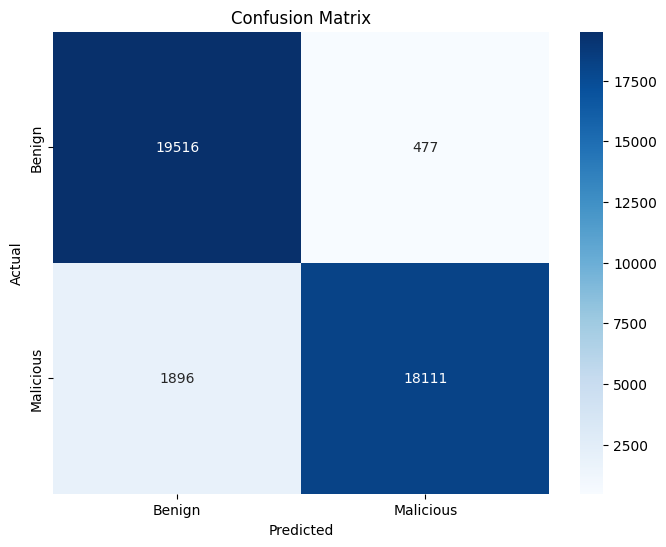

In [22]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

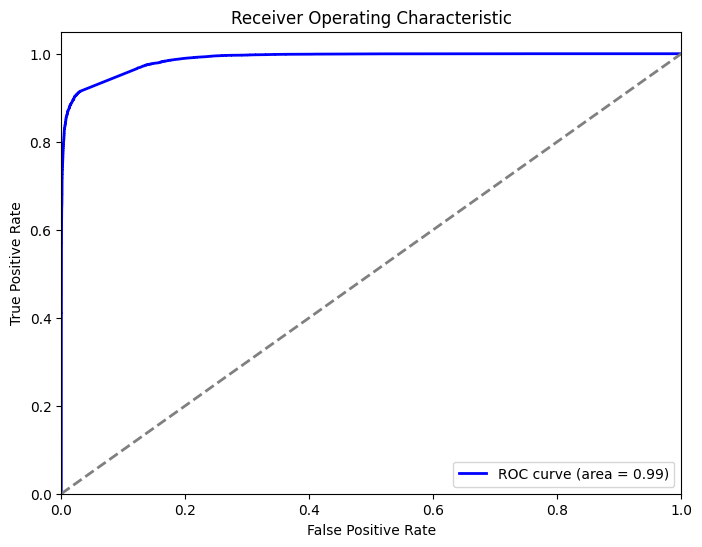

In [23]:
# Plot ROC curve
y_test_bin = to_categorical(y_test, num_classes)
fpr, tpr, _ = roc_curve(y_test_bin[:, 1], y_pred_cat[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [24]:
# # Benchmark DGA detectors
# benchmark_dga_detectors(X_train, y_train, X_test, y_test)

In [25]:
def classify_domain(domain_name, model, word2vec_model, word_probabilities):
    # Step 1: Tokenize the domain name
    tokens = dom2words(domain_name, word_probabilities)

    # Step 2: Generate embeddings
    sentence = tokens
    vectors = [word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv]
    if vectors:
        vectors_array = np.array(vectors)

        # Aggregation methods
        min_vec = np.min(vectors_array, axis=0)
        mean_vec = np.mean(vectors_array, axis=0)
        max_vec = np.max(vectors_array, axis=0)
        sum_vec = np.sum(vectors_array, axis=0)

        # TF-IDF weighting
        tfidf_vec = np.zeros(vectors_array.shape[1])
        for word in sentence:
            if word in word_probabilities:
                tfidf_vec += word2vec_model.wv[word] * word_probabilities[word]

        # Combine all aggregations
        embedding = np.concatenate([min_vec, mean_vec, max_vec, sum_vec, tfidf_vec])
    else:
        embedding = np.zeros(500)

    embedding = embedding.reshape((1, 500))  # Reshape to match input shape

    # Check input shape before prediction
    print(f"Embedding shape: {embedding.shape}")

    # Step 3: Make prediction
    try:
        prediction_prob = model.predict(embedding)
        prediction_class = np.argmax(prediction_prob, axis=1)
        return "Benign" if prediction_class[0] == 1 else "Malware"
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None

# Example usage
domain_name = 'sidrrsensinaix.com'
result = classify_domain(domain_name, deepd2v_model, model, word_probabilities)
print(f"The domain '{domain_name}' is classified as: {result}")


domain_name = 'google.com'
result = classify_domain(domain_name, deepd2v_model, model, word_probabilities)
print(f"The domain '{domain_name}' is classified as: {result}")



Embedding shape: (1, 500)
1/1 [==============================] - 1s 1s/step
The domain 'sidrrsensinaix.com' is classified as: Malware
Embedding shape: (1, 500)
1/1 [==============================] - 0s 407ms/step
The domain 'google.com' is classified as: Benign


In [26]:
from collections import Counter
print(Counter(labels))

y_train_pred = np.argmax(deepd2v_model.predict(X_train), axis=1)
y_test_pred = np.argmax(deepd2v_model.predict(X_test), axis=1)

print("Training set performance:")
print(classification_report(y_train, y_train_pred))

print("Test set performance:")
print(classification_report(y_test, y_test_pred))

from sklearn.metrics import confusion_matrix

# Make predictions
y_test_pred = np.argmax(deepd2v_model.predict(X_test), axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred))



Counter({0: 100000, 1: 100000})
1250/1250 [==============================] - 7s 5ms/step
Training set performance:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     80007
           1       0.97      0.90      0.94     79993

    accuracy                           0.94    160000
   macro avg       0.94      0.94      0.94    160000
weighted avg       0.94      0.94      0.94    160000

Test set performance:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     19993
           1       0.97      0.91      0.94     20007

    accuracy                           0.94     40000
   macro avg       0.94      0.94      0.94     40000
weighted avg       0.94      0.94      0.94     40000

1250/1250 [==============================] - 6s 5ms/step
Confusion Matrix:
[[19516   477]
 [ 1896 18111]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91  

# Heuristic-based (RV) classifier - no AI/ML involved, simple rule-based model

In [27]:
import os
from collections import defaultdict, Counter
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [28]:
# Files containing the data
malware_file = '/content/drive/MyDrive/Tasks (Ruman Malik)/Task 6 (DGA Detection)/Data/DGA.txt'
benign_file = '/content/drive/MyDrive/Tasks (Ruman Malik)/Task 6 (DGA Detection)/Data/top-100000-domains.txt'
dictionary_file = '/content/drive/MyDrive/Tasks (Ruman Malik)/Task 6 (DGA Detection)/Data/count_1w.txt'

# N values for N-Gram
n_values = [3, 4, 5, 6, 7]

In [29]:
# Step 1: Construct Domain Name Whitelist Substring Set

def read_file(file_path):
    """Reads a file and returns its content as a list of lines."""
    with open(file_path, 'r') as f:
        return f.read().splitlines()

def extract_domain_substrings(domains, n_values):
    """
    Extracts substrings of length N from the provided domain names.
    Args:
    domains: list of domain names.
    n_values: list of N values for N-Gram.
    Returns:
    A dictionary with substrings as keys and their frequencies as values.
    """
    substring_weights = Counter()
    for domain in domains:
        # Split the domain to remove the TLD
        parts = domain.split('.')
        if len(parts) > 1:
            # Exclude the top-level domain (TLD)
            domain_without_tld = '.'.join(parts[:-1])
        else:
            domain_without_tld = domain

        # Generate N-Gram substrings for different N values
        for n in n_values:
            for i in range(len(domain_without_tld) - n + 1):
                substring = domain_without_tld[i:i+n]
                substring_weights[substring] += 1
    return substring_weights

# Read benign domain names from the file
benign_domains = read_file(benign_file)

# Extract unique substrings from benign domains and their frequencies
whitelist_substrings = extract_domain_substrings(benign_domains, n_values)

In [30]:
# Step 2: Malicious Domain Detection Process

def calculate_reputation_value(domain, whitelist_substrings, n_values):
    """
    Calculate the reputation value (RV) of a domain based on its substrings' weights.
    Args:
    domain: domain name to check.
    whitelist_substrings: dictionary of known substrings with their weights.
    n_values: list of N values for N-Gram.
    Returns:
    Reputation value of the domain.
    """
    total_weight = 0
    total_substrings = 0

    # Remove top-level domain (TLD) from the test domain
    parts = domain.split('.')
    if len(parts) > 1:
        domain_without_tld = '.'.join(parts[:-1])
    else:
        domain_without_tld = domain

    # Generate N-Gram substrings for the domain
    for n in n_values:
        for i in range(len(domain_without_tld) - n + 1):
            substring = domain_without_tld[i:i+n]
            total_substrings += 1
            # Get the weight of the substring from the whitelist
            total_weight += whitelist_substrings.get(substring, 0)

    # Calculate the final reputation value (RV)
    if total_substrings > 0:
        return total_weight / total_substrings
    else:
        return 0

def is_malicious_domain(domain, whitelist_substrings, n_values, threshold):
    """
    Determine if a domain is malicious based on its reputation value.
    Args:
    domain: domain name to check.
    whitelist_substrings: dictionary of known substrings with their weights.
    n_values: list of N values for N-Gram.
    threshold: reputation threshold below which the domain is considered malicious.
    Returns:
    Boolean indicating if the domain is malicious.
    """
    reputation_value = calculate_reputation_value(domain, whitelist_substrings, n_values)
    return reputation_value < threshold

# Set the threshold for malicious domain names detection
threshold = 1.0

# Read malicious domain names from the file
malicious_domains = read_file(malware_file)

# Dictionary to store actual domain types for comparison
actual_classifications = {
    domain: "malicious" for domain in malicious_domains
}
actual_classifications.update({
    domain: "benign" for domain in benign_domains
})

# Detect and report malicious domains
predictions = []
actuals = []

for domain in actual_classifications.keys():
    prediction = "malicious" if is_malicious_domain(domain, whitelist_substrings, n_values, threshold) else "benign"
    actual = actual_classifications.get(domain, "unknown")  # Default to 'unknown' if not in the classification dictionary
    predictions.append(prediction)
    actuals.append(actual)
    print(f"Domain: {domain} | Prediction: {prediction} | Actual: {actual}")

Streaming output truncated to the last 5000 lines.
Domain: vitringez.com | Prediction: benign | Actual: benign
Domain: yesform.com | Prediction: benign | Actual: benign
Domain: zohur12.ir | Prediction: benign | Actual: benign
Domain: britishcycling.org.uk | Prediction: benign | Actual: benign
Domain: yaoihavenreborn.com | Prediction: benign | Actual: benign
Domain: e2bn.org | Prediction: benign | Actual: benign
Domain: telemat.org | Prediction: benign | Actual: benign
Domain: al-dreams.co | Prediction: benign | Actual: benign
Domain: digiex.net | Prediction: benign | Actual: benign
Domain: megaquizz.fr | Prediction: benign | Actual: benign
Domain: readymaderc.com | Prediction: benign | Actual: benign
Domain: imcdb.org | Prediction: benign | Actual: benign
Domain: velex.ir | Prediction: benign | Actual: benign
Domain: blogspot.sn | Prediction: benign | Actual: benign
Domain: uniturm.de | Prediction: benign | Actual: benign
Domain: uoko.com | Prediction: benign | Actual: benign
Domain: a

In [31]:
# Generate classification report
print("\nClassification Report:\n")
print(classification_report(actuals, predictions, target_names=["benign", "malicious"]))

# Optionally: Confusion Matrix
print("\nConfusion Matrix:\n")
conf_matrix = confusion_matrix(actuals, predictions, labels=["benign", "malicious"])
print(conf_matrix)


Classification Report:

              precision    recall  f1-score   support

      benign       0.60      0.99      0.75    100000
   malicious       0.97      0.27      0.42     89286

    accuracy                           0.65    189286
   macro avg       0.79      0.63      0.59    189286
weighted avg       0.78      0.65      0.59    189286


Confusion Matrix:

[[99369   631]
 [65366 23920]]


In [33]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

def find_best_threshold(predictions, actuals):
    thresholds = np.linspace(0, 1, 100)
    best_f1 = 0
    best_threshold = 0
    for threshold in thresholds:
        binary_predictions = [1 if p < threshold else 0 for p in predictions]
        report = classification_report(actuals, binary_predictions, output_dict=True, zero_division=0)
        f1 = report['1']['f1-score'] if '1' in report else 0
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold

# Step 1: Compute reputation values for all domains
reputation_values = []
for domain in actual_classifications.keys():
    rv = calculate_reputation_value(domain, whitelist_substrings, n_values)
    reputation_values.append(rv)

# Step 2: Convert reputation values to numeric predictions
numeric_reputation_values = [1 if rv < threshold else 0 for rv in reputation_values]
numeric_actuals = [1 if label == "malicious" else 0 for label in actuals]

# Step 3: Find the best threshold
best_threshold = find_best_threshold(reputation_values, numeric_actuals)
print(f"Optimal Threshold: {best_threshold:.2f}")

# Step 4: Recalculate predictions with the optimal threshold
optimal_predictions = [1 if rv < best_threshold else 0 for rv in reputation_values]

# Step 5: Generate updated classification report
print("\nClassification Report with Optimal Threshold:\n")
print(classification_report(numeric_actuals, optimal_predictions, target_names=["benign", "malicious"]))
print("\nConfusion Matrix:\n")
print(confusion_matrix(numeric_actuals, optimal_predictions))


Optimal Threshold: 1.00

Classification Report with Optimal Threshold:

              precision    recall  f1-score   support

      benign       0.60      0.99      0.75    100000
   malicious       0.97      0.27      0.42     89286

    accuracy                           0.65    189286
   macro avg       0.79      0.63      0.59    189286
weighted avg       0.78      0.65      0.59    189286


Confusion Matrix:

[[99369   631]
 [65366 23920]]


# RVP

In [36]:
import numpy as np
from collections import defaultdict
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm  # Importing tqdm for notebook progress bar
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import cosine



# Load datasets
malware_file = '/content/drive/MyDrive/Tasks (Ruman Malik)/Task 6 (DGA Detection)/Data/DGA.txt'
benign_file = '/content/drive/MyDrive/Tasks (Ruman Malik)/Task 6 (DGA Detection)/Data/top-100000-domains.txt'
dictionary_file = '/content/drive/MyDrive/Tasks (Ruman Malik)/Task 6 (DGA Detection)/Data/count_1w.txt'

def load_domains(file_path):
    with open(file_path, 'r') as file:
        return [line.strip() for line in file.readlines()]

malware_domains = load_domains(malware_file)
benign_domains = load_domains(benign_file)

# Split datasets:
benign_train, benign_test = train_test_split(benign_domains, test_size=0.0001, random_state=42)
malware_train, malware_test = train_test_split(malware_domains, test_size=0.0001, random_state=42)

# Combine test domains and create true labels
test_domains = benign_test + malware_test
true_labels = [0] * len(benign_test) + [1] * len(malware_test)  # 0: benign, 1: malicious

# Map numeric labels to names
label_map = {0: 'Benign', 1: 'Malicious'}

# Helper function to generate n-grams
def generate_ngrams(domain, n):
    return [domain[i:i+n] for i in range(len(domain)-n+1)]

# Create 3-gram hash table for SDD Filter
def create_3gram_table(domains):
    gram_table = defaultdict(set)
    for domain in domains:
        for gram in generate_ngrams(domain, 3):
            gram_table[gram].add(domain)
    return gram_table

whitelist_3gram_table = create_3gram_table(benign_train)

# Compute Levenshtein distance
def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row

    return previous_row[-1]

# SDD filter returning binary prediction with progress bar
def sdd_filter(domain, whitelist_domains, threshold=0.5):
    domain_ngrams = generate_ngrams(domain, 3)
    candidates = set()

    for gram in domain_ngrams:
        if gram in whitelist_3gram_table:
            candidates.update(whitelist_3gram_table[gram])

    for candidate in candidates:
        candidate_ngrams = generate_ngrams(candidate, 3)
        ps_value = len(set(domain_ngrams) & set(candidate_ngrams)) / len(candidate_ngrams)
        lev_distance = levenshtein_distance(domain, candidate)

        # Convert n-grams to binary vectors for Jaccard index and Cosine similarity
        combined_ngrams = list(set(domain_ngrams + candidate_ngrams))
        domain_vec = np.array([1 if gram in domain_ngrams else 0 for gram in combined_ngrams])
        candidate_vec = np.array([1 if gram in candidate_ngrams else 0 for gram in combined_ngrams])

        jaccard = jaccard_score(domain_vec, candidate_vec, average='binary')
        cosine_sim = 1 - cosine(domain_vec, candidate_vec)

        if lev_distance == 1 or ps_value > threshold or (ps_value > threshold and cosine_sim > threshold and jaccard > threshold):
            return 1  # Malicious
    return 0  # Benign

# DGA Filter returning binary prediction
def load_n_gram_count(file_path):
    n_gram_count = defaultdict(int)
    with open(file_path, 'r') as f:
        for line in f:
            ngram, count = line.strip().split('\t')
            n_gram_count[ngram] = int(count)
    return n_gram_count

n_gram_dict = load_n_gram_count(dictionary_file)

def calculate_rvp(domain, ngram_dict, min_n=3, max_n=7):
    total_rvp = 0
    domain_length = len(domain)

    for n in range(min_n, max_n + 1):
        ngrams = generate_ngrams(domain, n)
        for ngram in ngrams:
            if ngram in ngram_dict:
                total_rvp += (n / domain_length) * np.log2(ngram_dict[ngram] / n)

    return total_rvp

def dga_filter(domain, benign_threshold=10):
    rvp_score = calculate_rvp(domain, n_gram_dict)

    if rvp_score > benign_threshold:
        return 0  # Benign
    else:
        return 1  # Malicious

# Test the PHISHWEB system and generate classification report
from sklearn.metrics import classification_report

# Predictions from both SDD and DGA filters
sdd_predictions = []
dga_predictions = []

# Progress bar for SDD filter
print("Running SDD filter on test domains...")
for domain in tqdm(test_domains, desc="Processing SDD Filter", ncols=100, leave=True):
    sdd_predictions.append(sdd_filter(domain, benign_train))

# Progress bar for DGA filter
print("Running DGA filter on test domains...")
for domain in tqdm(test_domains, desc="Processing DGA Filter", ncols=100, leave=True):
    dga_predictions.append(dga_filter(domain))

# Average the predictions (you can also apply a more sophisticated ensemble strategy)
final_predictions = [(sdd + dga) // 2 for sdd, dga in zip(sdd_predictions, dga_predictions)]

# Generate classification report
report = classification_report(true_labels, final_predictions, target_names=['Benign', 'Malicious'], output_dict=True)

print("Classification Report for PHISHWEB System:")
print(f"{'Class':<12} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<6}")
for label, metrics in report.items():
    if label in ['accuracy', 'macro avg', 'weighted avg']:
        continue
    print(f"{label:<12} {metrics['precision']:<10.2f} {metrics['recall']:<10.2f} {metrics['f1-score']:<10.2f} {metrics['support']:<6.0f}")

print("\nOverall Accuracy:", report['accuracy'])
print("Macro Average Precision:", report['macro avg']['precision'])
print("Macro Average Recall:", report['macro avg']['recall'])
print("Macro Average F1-Score:", report['macro avg']['f1-score'])
print("Weighted Average Precision:", report['weighted avg']['precision'])
print("Weighted Average Recall:", report['weighted avg']['recall'])
print("Weighted Average F1-Score:", report['weighted avg']['f1-score'])

# Show test domain predictions with actual labels
print("\nTest Domain Predictions:")
for domain, true_label, sdd_pred, dga_pred, final_pred in zip(test_domains, true_labels, sdd_predictions, dga_predictions, final_predictions):
    true_label_name = label_map[true_label]
    sdd_pred_name = label_map[sdd_pred]
    dga_pred_name = label_map[dga_pred]
    final_pred_name = label_map[final_pred]
    print(f"Domain: {domain}, True Label: {true_label_name}, SDD Prediction: {sdd_pred_name}, DGA Prediction: {dga_pred_name}, Final Prediction: {final_pred_name}")


Running SDD filter on test domains...


Processing SDD Filter:   0%|                                                 | 0/20 [00:00<?, ?it/s]

Running DGA filter on test domains...


Processing DGA Filter:   0%|                                                 | 0/20 [00:00<?, ?it/s]

Classification Report for PHISHWEB System:
Class        Precision  Recall     F1-Score   Support
Benign       0.53       1.00       0.69       10    
Malicious    1.00       0.10       0.18       10    

Overall Accuracy: 0.55
Macro Average Precision: 0.763157894736842
Macro Average Recall: 0.55
Macro Average F1-Score: 0.4357366771159875
Weighted Average Precision: 0.7631578947368421
Weighted Average Recall: 0.55
Weighted Average F1-Score: 0.43573667711598746

Test Domain Predictions:
Domain: unisci24.com, True Label: Benign, SDD Prediction: Malicious, DGA Prediction: Benign, Final Prediction: Benign
Domain: autoinvest.biz, True Label: Benign, SDD Prediction: Malicious, DGA Prediction: Benign, Final Prediction: Benign
Domain: beelzeboulxxx.com, True Label: Benign, SDD Prediction: Malicious, DGA Prediction: Benign, Final Prediction: Benign
Domain: freephototool.com, True Label: Benign, SDD Prediction: Malicious, DGA Prediction: Benign, Final Prediction: Benign
Domain: dstrack1.com, True

# MN-grams

In [38]:
!pip install boruta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 2.3 MB/s eta 0:00:00


In [41]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import VarianceThreshold
from tqdm.notebook import tqdm

# Load data from text files
def load_text_data(file_path, label):
    with open(file_path, 'r') as file:
        domains = file.readlines()
    return pd.DataFrame({'domain': [domain.strip() for domain in domains], 'label': label})

# Paths to data files
malware_file = '/content/drive/MyDrive/Tasks (Ruman Malik)/Task 6 (DGA Detection)/Data/dga-bader-32k.txt'
benign_file = '/content/drive/MyDrive/Tasks (Ruman Malik)/Task 6 (DGA Detection)/Data/clean-alexa-32k.txt'

# Load and preprocess data
malware_data = load_text_data(malware_file, 'malware')
benign_data = load_text_data(benign_file, 'benign')
data = pd.concat([malware_data, benign_data], ignore_index=True)
data = data.sample(frac=1).reset_index(drop=True)

# Mask domains
def mask_domain(domain):
    # Replace vowels with 'v', digits with 'n', and remaining consonants with 's'
    masked = re.sub(r'[aeiou]', 'v', re.sub(r'[0-9]', 'n', re.sub(r'[^a-z0-9]', '', domain.lower())))
    return re.sub(r'[^cvn]', 's', masked)

data['masked_domain'] = data['domain'].apply(mask_domain)

# Filter out any empty or invalid masked domains
data = data[data['masked_domain'].str.strip().astype(bool)]
print(f"Number of valid domains after masking: {len(data)}")

# Extract features
def extract_features(domain):
    if not domain.strip():  # Ensure the domain is not empty
        return {}
    vectorizer = CountVectorizer(ngram_range=(1, 4), analyzer='char', stop_words=None)
    X = vectorizer.fit_transform([domain])
    return dict(zip(vectorizer.get_feature_names_out(), X.toarray()[0]))

# Track invalid domains for debugging
invalid_domains = []
features_list = []

# Extract features with a progress bar
for domain in tqdm(data['masked_domain'], desc='Extracting Features'):
    try:
        features = extract_features(domain)
        features_list.append(features)
    except ValueError:
        invalid_domains.append(domain)

# Log the number of invalid domains
print(f"Number of invalid domains: {len(invalid_domains)}")

# Convert features into a DataFrame
features_df = pd.DataFrame(features_list).fillna(0)
features_df['label'] = data['label'].values

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
features_df['label'] = le.fit_transform(features_df['label'])

# Convert to NumPy arrays for faster processing
X = features_df.drop('label', axis=1).values
y = features_df['label'].values

# Preliminary Feature Selection: Variance Threshold
print("Performing preliminary feature selection...")
selector = VarianceThreshold(threshold=0.01)
X_reduced = selector.fit_transform(X)

# Align features with the reduced feature set
selected_feature_names = np.array(features_df.columns[:-1])[selector.get_support()]
print(f"Reduced features from {X.shape[1]} to {len(selected_feature_names)}")

# Update features_df to include only selected features
features_df_reduced = features_df[selected_feature_names.tolist() + ['label']]


Number of valid domains after masking: 257106


Extracting Features:   0%|          | 0/257106 [00:00<?, ?it/s]

Number of invalid domains: 0
Performing preliminary feature selection...
Reduced features from 340 to 169


In [43]:
from sklearn.model_selection import KFold

# Experiment 1: Standard Random Forest with all features
def run_experiment_1(X, y):
    rf_model = RandomForestClassifier(n_estimators=500, max_depth=None, n_jobs=-1, random_state=42)
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    results = []

    for train_index, test_index in tqdm(kf.split(X), desc='Fitting Random Forest', total=kf.get_n_splits()):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)
        report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
        results.append(report)

    # Compute average metrics
    avg_report = {}
    for metric in ['precision', 'recall', 'f1-score']:
        avg_report[metric] = {label: np.mean([report[label][metric] for report in results if label in report])
                              for label in le.classes_}

    avg_report_df = pd.DataFrame(avg_report)
    return avg_report_df



In [44]:
# Run Experiment 1
print("Experiment 1: Standard Random Forest with all features")
experiment_1_report = run_experiment_1(X, y)
print(experiment_1_report)


Experiment 1: Standard Random Forest with all features


Fitting Random Forest:   0%|          | 0/10 [00:00<?, ?it/s]

         precision    recall  f1-score
benign    0.675169  0.570113  0.541742
malware   0.667990  0.625578  0.563240


In [45]:
# Experiment 2: Feature Selection with Boruta
rf = RandomForestClassifier(n_estimators=500, max_depth=None, n_jobs=-1, random_state=42)
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)

print("Experiment 2: Feature Selection with Boruta")
boruta.fit(X_reduced, y)


Experiment 2: Feature Selection with Boruta
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	169
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	169
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	169
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	169
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	169
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	169
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	169
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	166
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	166
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	166
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	166
Iteration: 	12 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	166
Iteration: 	13 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	166
Iteration: 	14 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	166
Iteration: 	15 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	166
Itera

BorutaPy(estimator=RandomForestClassifier(n_estimators=20, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7D15DC603D40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7D15DC603D40, verbose=2)

In [48]:
# Select important features
important_features = selected_feature_names[boruta.support_]
X_selected = features_df[important_features.tolist() + ['label']].values

# Save the new dataset with important features
important_features_df = pd.DataFrame(X_selected, columns=important_features.tolist() + ['label'])
important_features_df['label'] = y
important_features_df.to_csv('/content/drive/MyDrive/important_features_dataset.csv', index=False)


In [49]:
# Experiment 3: Random Forest with selected features
print("\nExperiment 3: Random Forest with selected features from Boruta")
experiment_3_report = run_experiment_1(X_selected, y)
print(experiment_3_report)



Experiment 3: Random Forest with selected features from Boruta


Fitting Random Forest:   0%|          | 0/10 [00:00<?, ?it/s]

         precision  recall  f1-score
benign         1.0     1.0       1.0
malware        1.0     1.0       1.0


# RF3

In [50]:
import re
import math
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec
from gensim.models import FastText

# Load dictionary and frequency data
def load_dictionary(file_path):
    dictionary = {}
    with open(file_path, 'r') as file:
        for line in file:
            word, freq = line.strip().split()
            dictionary[word] = int(freq)
    return dictionary

# Load domain data
def load_domains(file_path):
    with open(file_path, 'r') as file:
        return [line.strip() for line in file]

# Calculate word probabilities using Zipf's law
def calculate_word_probabilities(dictionary):
    sorted_words = sorted(dictionary.items(), key=lambda x: x[1], reverse=True)
    total_words = len(sorted_words)
    word_probabilities = {}
    for rank, (word, freq) in enumerate(sorted_words, start=1):
        probability = 1 / (rank * math.log(total_words))
        word_probabilities[word] = probability
    return word_probabilities

# Split domain names into words or tokens using probabilistic approach
def dom2words(domain, word_probabilities):
    tokens = re.findall(r'[a-zA-Z0-9]+', domain)  # Extract tokens of letters and numbers
    result = []

    for token in tokens:
        n = len(token)
        dp = [-float('inf')] * (n + 1)  # DP array to keep track of segmentation probabilities
        split = [None] * (n + 1)  # To store the split positions

        dp[0] = 0  # Start with zero probability

        for i in range(1, n + 1):
            for j in range(i):
                word = token[j:i]
                if word in word_probabilities:
                    prob = dp[j] + math.log(word_probabilities[word])
                    if prob > dp[i]:
                        dp[i] = prob
                        split[i] = j

        # Reconstruct the words from the split
        words = []
        idx = n
        while idx > 0:
            prev_idx = split[idx]
            if prev_idx is None:
                break
            words.append(token[prev_idx:idx])
            idx = prev_idx

        result.extend(reversed(words))

    return result

# Dom2Vec model: train Word2Vec on domain sentences and create embeddings
def train_word2vec(domains, vector_size=100, window=5, min_count=1):
    sentences = [dom2words(domain, word_probabilities) for domain in domains]
    model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, sg=1)
    return model

# Generate domain embeddings with Dom2Vec
def generate_embeddings(domains, model):
    embeddings = []
    for domain in domains:
        words = dom2words(domain, word_probabilities)
        vectors = [model.wv[word] for word in words if word in model.wv]
        if vectors:
            embedding = np.concatenate([
                np.min(vectors, axis=0),
                np.mean(vectors, axis=0),
                np.max(vectors, axis=0),
                np.sum(vectors, axis=0),
                np.average(vectors, axis=0, weights=[model.wv.get_vecattr(word, 'count') for word in words if word in model.wv])
            ])
            embeddings.append(embedding)
        else:
            embeddings.append(np.zeros(500))
    return np.array(embeddings)

# Calculate RVP score
def calculate_rvp(domain, word_probabilities, reputation_list):
    n = len(domain)
    rvp_score = 0
    for length in range(3, 8):  # N-gram lengths from 3 to 7
        for i in range(n - length + 1):
            ngram = domain[i:i + length]
            if ngram in reputation_list:
                rvp_score += math.log2(reputation_list[ngram] / length)
    return rvp_score

# Calculate entropy
def calculate_entropy(domain):
    char_freq = pd.Series(list(domain)).value_counts(normalize=True)
    return -np.sum(char_freq * np.log2(char_freq + 1e-9))

# Load data
malware_domains = load_domains('/content/drive/MyDrive/Tasks (Ruman Malik)/Task 6 (DGA Detection)/Data/DGA.txt')
benign_domains = load_domains('/content/drive/MyDrive/Tasks (Ruman Malik)/Task 6 (DGA Detection)/Data/top-100000-domains.txt')
dictionary = load_dictionary('/content/drive/MyDrive/Tasks (Ruman Malik)/Task 6 (DGA Detection)/Data/count_1w.txt')

# Calculate word probabilities and reputation list
word_probabilities = calculate_word_probabilities(dictionary)
reputation_list = {word: freq for word, freq in dictionary.items()}

# Train Dom2Vec model
model = train_word2vec(malware_domains + benign_domains)

# Generate embeddings for all domains
malware_embeddings = generate_embeddings(malware_domains, model)
benign_embeddings = generate_embeddings(benign_domains, model)

# Prepare dataset for RF3
X = np.concatenate([malware_embeddings, benign_embeddings])
y = np.concatenate([np.ones(len(malware_domains)), np.zeros(len(benign_domains))])

# Calculate RVP and entropy
rvps = np.array([calculate_rvp(domain, word_probabilities, reputation_list) for domain in malware_domains + benign_domains])
entropies = np.array([calculate_entropy(domain) for domain in malware_domains + benign_domains])

# Combine features
features = np.column_stack([rvps, np.array([len(domain) for domain in malware_domains + benign_domains]), entropies])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3, random_state=42)

# Train Random Forest
rf3 = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
rf3.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf3.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')


Accuracy: 0.8740166666666667


# RFD2V

              precision    recall  f1-score   support

           0       0.95      0.91      0.93     30149
           1       0.91      0.95      0.93     29851

    accuracy                           0.93     60000
   macro avg       0.93      0.93      0.93     60000
weighted avg       0.93      0.93      0.93     60000



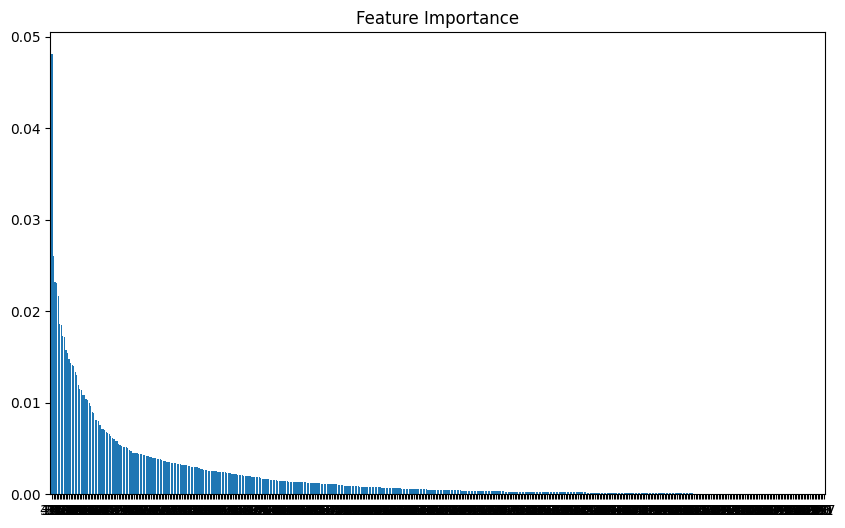

In [51]:
import pandas as pd
import numpy as np
import math
import re
import gensim
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Load dictionary and frequency data
def load_dictionary(file_path):
    dictionary = {}
    with open(file_path, 'r') as file:
        for line in file:
            word, freq = line.strip().split()
            dictionary[word] = int(freq)
    return dictionary

# Load domain data
def load_domains(file_path):
    with open(file_path, 'r') as file:
        return [line.strip() for line in file]

# Calculate word probabilities using Zipf's law
def calculate_word_probabilities(dictionary):
    sorted_words = sorted(dictionary.items(), key=lambda x: x[1], reverse=True)
    total_words = len(sorted_words)
    word_probabilities = {}
    for rank, (word, freq) in enumerate(sorted_words, start=1):
        probability = 1 / (rank * math.log(total_words))
        word_probabilities[word] = probability
    return word_probabilities

# Split domain names into words or tokens using probabilistic approach
def dom2words(domain, word_probabilities):
    tokens = re.findall(r'[a-zA-Z0-9]+', domain)  # Extract tokens of letters and numbers
    result = []

    for token in tokens:
        n = len(token)
        dp = [-float('inf')] * (n + 1)  # DP array to keep track of segmentation probabilities
        split = [None] * (n + 1)  # To store the split positions

        dp[0] = 0  # Start with zero probability

        for i in range(1, n + 1):
            for j in range(i):
                word = token[j:i]
                if word in word_probabilities:
                    prob = dp[j] + math.log(word_probabilities[word])
                    if prob > dp[i]:
                        dp[i] = prob
                        split[i] = j

        # Reconstruct the words from the split
        words = []
        idx = n
        while idx > 0:
            prev_idx = split[idx]
            if prev_idx is None:
                break
            words.append(token[prev_idx:idx])
            idx = prev_idx

        result.extend(reversed(words))

    return result

# Prepare data for Dom2Vec
def preprocess_dom2vec(domains, word_probabilities):
    sentences = [dom2words(domain, word_probabilities) for domain in domains]
    return sentences

# Train Word2Vec model
def train_word2vec(sentences, size=100, window=5):
    model = Word2Vec(sentences, vector_size=size, window=window, sg=1, min_count=1)
    return model

def compute_embeddings(sentences, model):
    def get_embedding(words):
        # Filter out words not in the model's vocabulary
        valid_words = [word for word in words if word in model.wv]
        if not valid_words:
            return np.zeros(model.vector_size * 5)  # Return a zero vector of the appropriate size

        embeddings = np.array([model.wv[word] for word in valid_words])

        # Compute different pooling techniques
        min_pooling = np.min(embeddings, axis=0)
        mean_pooling = np.mean(embeddings, axis=0)
        max_pooling = np.max(embeddings, axis=0)
        sum_pooling = np.sum(embeddings, axis=0)

        # Compute TF-IDF weighted embedding
        embedding_sum = np.sum(embeddings, axis=0)
        # Avoid log(0) by ensuring non-zero sums
        if np.any(embedding_sum <= 0):
            embedding_sum[embedding_sum <= 0] = 1e-10
        tfidf_weights = np.array([
            model.wv[word] * (1 / (1 + np.log(1 + np.sum(embedding_sum))))
            for word in valid_words
        ])

        # Avoid empty tfidf_weights
        if tfidf_weights.size == 0:
            tfidf_pooling = np.zeros(model.vector_size)
        else:
            tfidf_pooling = np.sum(tfidf_weights, axis=0)

        return np.concatenate([min_pooling, mean_pooling, max_pooling, sum_pooling, tfidf_pooling])

    return np.array([get_embedding(words) for words in sentences])


# Load data
malware_file = '/content/drive/MyDrive/Tasks (Ruman Malik)/Task 6 (DGA Detection)/Data/DGA.txt'
benign_file = '/content/drive/MyDrive/Tasks (Ruman Malik)/Task 6 (DGA Detection)/Data/top-100000-domains.txt'
dictionary_file = '/content/drive/MyDrive/Tasks (Ruman Malik)/Task 6 (DGA Detection)/Data/count_1w.txt'

malware_domains = load_domains(malware_file)
benign_domains = load_domains(benign_file)
dictionary = load_dictionary(dictionary_file)
word_probabilities = calculate_word_probabilities(dictionary)

# Preprocess domains
malware_sentences = preprocess_dom2vec(malware_domains, word_probabilities)
benign_sentences = preprocess_dom2vec(benign_domains, word_probabilities)

# Train Word2Vec model
all_sentences = malware_sentences + benign_sentences
word2vec_model = train_word2vec(all_sentences)

# Compute embeddings
malware_embeddings = compute_embeddings(malware_sentences, word2vec_model)
benign_embeddings = compute_embeddings(benign_sentences, word2vec_model)

# Create labels and prepare data
X = np.vstack([malware_embeddings, benign_embeddings])
y = np.array([1] * len(malware_embeddings) + [0] * len(benign_embeddings))

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest model
rfd2v_model = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
rfd2v_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = rfd2v_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot feature importance
importances = rfd2v_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title('Feature Importance')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()


# XD2V

In [53]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.3 MB/s eta 0:00:00


In [54]:
import numpy as np
import pandas as pd
import xgboost as xgb
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Load dictionary and frequency data
def load_dictionary(file_path):
    dictionary = {}
    with open(file_path, 'r') as file:
        for line in file:
            word, freq = line.strip().split()
            dictionary[word] = int(freq)
    return dictionary

# Load domain data
def load_domains(file_path):
    with open(file_path, 'r') as file:
        return [line.strip() for line in file]

# Calculate word probabilities using Zipf's law
def calculate_word_probabilities(dictionary):
    sorted_words = sorted(dictionary.items(), key=lambda x: x[1], reverse=True)
    total_words = len(sorted_words)
    word_probabilities = {}
    for rank, (word, freq) in enumerate(sorted_words, start=1):
        probability = 1 / (rank * np.log(total_words))
        word_probabilities[word] = probability
    return word_probabilities

# Split domain names into words or tokens using probabilistic approach
def dom2words(domain, word_probabilities):
    import re
    import math

    tokens = re.findall(r'[a-zA-Z0-9]+', domain)  # Extract tokens of letters and numbers
    result = []

    for token in tokens:
        n = len(token)
        dp = [-float('inf')] * (n + 1)  # DP array to keep track of segmentation probabilities
        split = [None] * (n + 1)  # To store the split positions

        dp[0] = 0  # Start with zero probability

        for i in range(1, n + 1):
            for j in range(i):
                word = token[j:i]
                if word in word_probabilities:
                    prob = dp[j] + np.log(word_probabilities[word])
                    if prob > dp[i]:
                        dp[i] = prob
                        split[i] = j

        # Reconstruct the words from the split
        words = []
        idx = n
        while idx > 0:
            prev_idx = split[idx]
            if prev_idx is None:
                break
            words.append(token[prev_idx:idx])
            idx = prev_idx

        result.extend(reversed(words))

    return result

# Compute embeddings using Word2Vec
def compute_embeddings(sentences, model):
    def get_embedding(words):
        # Filter out words not in the model's vocabulary
        valid_words = [word for word in words if word in model.wv]
        if not valid_words:
            return np.zeros(model.vector_size * 5)  # Return a zero vector of the appropriate size

        embeddings = np.array([model.wv[word] for word in valid_words])

        # Compute different pooling techniques
        min_pooling = np.min(embeddings, axis=0)
        mean_pooling = np.mean(embeddings, axis=0)
        max_pooling = np.max(embeddings, axis=0)
        sum_pooling = np.sum(embeddings, axis=0)

        # Compute TF-IDF weighted embedding
        embedding_sum = np.sum(embeddings, axis=0)
        # Avoid log(0) by ensuring non-zero sums
        if np.any(embedding_sum <= 0):
            embedding_sum[embedding_sum <= 0] = 1e-10
        tfidf_weights = np.array([
            model.wv[word] * (1 / (1 + np.log(1 + np.sum(embedding_sum))))
            for word in valid_words
        ])

        # Avoid empty tfidf_weights
        if tfidf_weights.size == 0:
            tfidf_pooling = np.zeros(model.vector_size)
        else:
            tfidf_pooling = np.sum(tfidf_weights, axis=0)

        return np.concatenate([min_pooling, mean_pooling, max_pooling, sum_pooling, tfidf_pooling])

    return np.array([get_embedding(words) for words in sentences])

# Load and preprocess data
def load_data():
    malware_file = '/content/drive/MyDrive/Tasks (Ruman Malik)/Task 6 (DGA Detection)/Data/DGA.txt'
    benign_file = '/content/drive/MyDrive/Tasks (Ruman Malik)/Task 6 (DGA Detection)/Data/top-100000-domains.txt'
    dictionary_file = '/content/drive/MyDrive/Tasks (Ruman Malik)/Task 6 (DGA Detection)/Data/count_1w.txt'

    dictionary = load_dictionary(dictionary_file)
    word_probabilities = calculate_word_probabilities(dictionary)

    malware_domains = load_domains(malware_file)
    benign_domains = load_domains(benign_file)

    malware_labels = [1] * len(malware_domains)
    benign_labels = [0] * len(benign_domains)

    all_domains = malware_domains + benign_domains
    all_labels = malware_labels + benign_labels

    # Split domains into words
    all_sentences = [dom2words(domain, word_probabilities) for domain in all_domains]

    return all_sentences, all_labels

# Train and evaluate XD2V model
def train_xd2v():
    all_sentences, all_labels = load_data()

    # Load pre-trained Word2Vec model
    model = Word2Vec(sentences=all_sentences, vector_size=100, window=5, min_count=1, sg=1)

    # Compute embeddings
    embeddings = compute_embeddings(all_sentences, model)

    # Convert labels to numpy array
    labels = np.array(all_labels)

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.3, random_state=42)

    # Initialize and train XGBoost model
    xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=6, objective='binary:logistic', eval_metric='logloss')
    xgb_model.fit(X_train, y_train)

    # Make predictions
    y_pred = xgb_model.predict(X_test)

    # Evaluate the model
    print(classification_report(y_test, y_pred))

# Run training and evaluation
train_xd2v()


              precision    recall  f1-score   support

           0       0.98      0.92      0.95     30149
           1       0.92      0.98      0.95     29851

    accuracy                           0.95     60000
   macro avg       0.95      0.95      0.95     60000
weighted avg       0.95      0.95      0.95     60000



# LightD2V

In [56]:
!pip install lightgbm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 35.1 MB/s eta 0:00:00


In [57]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Load dictionary and frequency data
# dictionary[w]=frequency
def load_dictionary(file_path):
    dictionary = {}
    with open(file_path, 'r') as file:
        for line in file:
            word, freq = line.strip().split()
            dictionary[word] = int(freq)
    return dictionary

# Load domain data
# file_path: Path to the file containing domain names.
# domains: A list of domain names, each stripped of leading/trailing whitespace.

def load_domains(file_path):
    with open(file_path, 'r') as file:
        return [line.strip() for line in file]

# Calculate word probabilities using Zipf's law
# dictionary: The word-frequency dictionary.
# sorted_words: Words sorted by frequency.
# probability: Computed probability for each word based on its rank and frequency.

# P(w) = 1 / (rank x log(total_words))  where rank is the position of the word when sorted by frequency.

def calculate_word_probabilities(dictionary):
    sorted_words = sorted(dictionary.items(), key=lambda x: x[1], reverse=True)
    total_words = len(sorted_words)
    word_probabilities = {}
    for rank, (word, freq) in enumerate(sorted_words, start=1):
        probability = 1 / (rank * np.log(total_words))
        word_probabilities[word] = probability
    return word_probabilities

# Split domain names into words or tokens using probabilistic approach
# DP Array: dp[i] stores the highest probability for the first i characters
# Word Probability Calculation: prob=dp[j]+log(P(w))
# Segmentation: split[i]=j if prob>dp[i]

def dom2words(domain, word_probabilities):
    import re
    import math

    tokens = re.findall(r'[a-zA-Z0-9]+', domain)  # Extract tokens of letters and numbers
    result = []

    for token in tokens:
        n = len(token)
        dp = [-float('inf')] * (n + 1)  # DP array to keep track of segmentation probabilities
        split = [None] * (n + 1)  # To store the split positions

        dp[0] = 0  # Start with zero probability

        for i in range(1, n + 1):
            for j in range(i):
                word = token[j:i]
                if word in word_probabilities:
                    prob = dp[j] + np.log(word_probabilities[word])
                    if prob > dp[i]:
                        dp[i] = prob
                        split[i] = j

        # Reconstruct the words from the split
        words = []
        idx = n
        while idx > 0:
            prev_idx = split[idx]
            if prev_idx is None:
                break
            words.append(token[prev_idx:idx])
            idx = prev_idx

        result.extend(reversed(words))

    return result

# Compute embeddings using Word2Vec
def compute_embeddings(sentences, model):
    def get_embedding(words):
        # Filter out words not in the model's vocabulary
        valid_words = [word for word in words if word in model.wv]
        if not valid_words:
            return np.zeros(model.vector_size * 5)  # Return a zero vector of the appropriate size

        embeddings = np.array([model.wv[word] for word in valid_words])

        # Compute different pooling techniques
        min_pooling = np.min(embeddings, axis=0)
        mean_pooling = np.mean(embeddings, axis=0)
        max_pooling = np.max(embeddings, axis=0)
        sum_pooling = np.sum(embeddings, axis=0)

        # Compute TF-IDF weighted embedding
        embedding_sum = np.sum(embeddings, axis=0)
        # Avoid log(0) by ensuring non-zero sums
        if np.any(embedding_sum <= 0):
            embedding_sum[embedding_sum <= 0] = 1e-10
        tfidf_weights = np.array([
            model.wv[word] * (1 / (1 + np.log(1 + np.sum(embedding_sum))))
            for word in valid_words
        ])

        # Avoid empty tfidf_weights
        if tfidf_weights.size == 0:
            tfidf_pooling = np.zeros(model.vector_size)
        else:
            tfidf_pooling = np.sum(tfidf_weights, axis=0)

        return np.concatenate([min_pooling, mean_pooling, max_pooling, sum_pooling, tfidf_pooling])

    return np.array([get_embedding(words) for words in sentences])

# Load and preprocess data
def load_data():
    malware_file = '/content/drive/MyDrive/Tasks (Ruman Malik)/Task 6 (DGA Detection)/Data/DGA.txt'
    benign_file = '/content/drive/MyDrive/Tasks (Ruman Malik)/Task 6 (DGA Detection)/Data/top-100000-domains.txt'
    dictionary_file = '/content/drive/MyDrive/Tasks (Ruman Malik)/Task 6 (DGA Detection)/Data/count_1w.txt'

    dictionary = load_dictionary(dictionary_file)
    word_probabilities = calculate_word_probabilities(dictionary)

    malware_domains = load_domains(malware_file)
    benign_domains = load_domains(benign_file)

    malware_labels = [1] * len(malware_domains)
    benign_labels = [0] * len(benign_domains)

    all_domains = malware_domains + benign_domains
    all_labels = malware_labels + benign_labels

    # Split domains into words
    all_sentences = [dom2words(domain, word_probabilities) for domain in all_domains]

    return all_sentences, all_labels

# Train and evaluate LightD2V model
def train_lightd2v():
    all_sentences, all_labels = load_data()

    # Load pre-trained Word2Vec model
    model = Word2Vec(sentences=all_sentences, vector_size=100, window=5, min_count=1, sg=1)

    # Compute embeddings
    embeddings = compute_embeddings(all_sentences, model)

    # Convert labels to numpy array
    labels = np.array(all_labels)

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.3, random_state=42)

    # Initialize and train LightGBM model
    lgb_model = lgb.LGBMClassifier(n_estimators=100, max_depth=6)
    lgb_model.fit(X_train, y_train)

    # Make predictions
    y_pred = lgb_model.predict(X_test)

    # Evaluate the model
    print(classification_report(y_test, y_pred))

# Run training and evaluation
train_lightd2v()


[LightGBM] [Info] Number of positive: 70149, number of negative: 69851
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 125271
[LightGBM] [Info] Number of data points in the train set: 140000, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501064 -> initscore=0.004257
[LightGBM] [Info] Start training from score 0.004257
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     30149
           1       0.92      0.97      0.95     29851

    accuracy                           0.94     60000
   macro avg       0.95      0.94      0.94     60000
weighted avg       0.95      0.94      0.94     60000

